In [1]:
import pandas as pd
import numpy as np
import pickle
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt

class Evaluation():
    def __init__(self, q_documentID, q_fullText, q_authorID, correct):
        self.q_documentID = q_documentID
        self.q_fullText = q_fullText
        self.q_authorID = q_authorID
        self.correct = correct
        self.c_texts = []
        self.c_authors = []

def cosine_sim(a, b):
    # Convert lists to NumPy arrays and flatten them
    a = np.array(a).flatten()
    b = np.array(b).flatten()

    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim 

data = pd.read_json("pilot_study_data_for_label_studio.json")['data']
with open('features_dict.pkl', 'rb') as f:
    features_dict = pickle.load(f)

norm_dict = features_dict.set_index('documentID').T.to_dict('list')

with open('gram_names.txt', 'r', encoding='utf-8') as f:
    gram_names = f.read().splitlines()

eval_examples = []
for example in data:
    eval_example = Evaluation(example['Q_documentID'], example['Q_fullText'], example['Q_authorID'], example['correct_idx'])
    eval_example.c_texts.append(example['a0_documentID'])
    eval_example.c_texts.append(example['a1_documentID'])
    eval_example.c_texts.append(example['a2_documentID'])
    eval_example.c_texts.append(example['a3_documentID'])
    eval_example.c_authors.append(example['a0_authorID'])
    eval_example.c_authors.append(example['a1_authorID'])
    eval_example.c_authors.append(example['a2_authorID'])
    eval_example.c_authors.append(example['a3_authorID'])
    eval_examples.append(eval_example)

def calculate_cosim(query, candidates):
    q = norm_dict[query][2]

    max_sim = -999999
    most_similar = query
    author = norm_dict[query][0]
    cosims, candidate_feature_vectors = [], []
    query_features = norm_dict[query][2]

    for i, c in enumerate(candidates):
        c_features = norm_dict[c][2]
        query_features = np.vstack((query_features, c_features))

    for candidate in candidates:
        c = norm_dict[candidate][2]
        candidate_feature_vectors.append(c)
        cosim = cosine_sim(q, c)
        cosims.append(round(cosim, 3))
        if cosim > max_sim:
            max_sim = cosim
            most_similar = candidate

    chosen = most_similar
    author = norm_dict[chosen][0]
    chosen_features = norm_dict[chosen][2]
    
    features_df = pd.DataFrame(query_features, columns=gram_names)

    unique_value_columns = features_df.loc[1:4].nunique() != 1
    filtered_df = features_df.loc[:, unique_value_columns]

    return candidate_feature_vectors, chosen, chosen_features, author, max_sim.round(4), filtered_df

def count_min_differences(features):
    # count number of instances of minimum being candidate - query
    q_features = features.iloc[0].to_numpy()
    a0 = features.iloc[1].to_numpy()
    a1 = features.iloc[2].to_numpy()
    a2 = features.iloc[3].to_numpy()
    a3 = features.iloc[4].to_numpy()

    a0_indices, a1_indices, a2_indices, a3_indices = [], [] ,[] ,[]
    a0_difs, a1_difs, a2_difs, a3_difs = {}, {}, {}, {}
    combined_top_indices = np.argsort(-np.abs(q_features))[:len(q_features)]

    for i in combined_top_indices:
        a0_dif = q_features[i] - a0[i]
        a1_dif = q_features[i] - a1[i]
        a2_dif = q_features[i] - a2[i]
        a3_dif = q_features[i] - a3[i]

        if min(a0_dif, a1_dif, a2_dif, a3_dif) == a0_dif:
            a0_indices.append(i)
            a0_difs[i] = abs(a0_dif)
        elif min(a0_dif, a1_dif, a2_dif, a3_dif) == a1_dif:
            a1_indices.append(i)
            a1_difs[i] = abs(a1_dif)
        elif min(a0_dif, a1_dif, a2_dif, a3_dif) == a2_dif:
            a2_indices.append(i)
            a2_difs[i] = abs(a2_dif)
        elif min(a0_dif, a1_dif, a2_dif, a3_dif) == a3_dif:
            a3_indices.append(i)
            a3_difs[i] = abs(a3_dif)

    a0_difs = {k: v for k, v in sorted(a0_difs.items(), key=lambda item: item[1])}
    a1_difs = {k: v for k, v in sorted(a1_difs.items(), key=lambda item: item[1])}
    a2_difs = {k: v for k, v in sorted(a2_difs.items(), key=lambda item: item[1])}
    a3_difs = {k: v for k, v in sorted(a3_difs.items(), key=lambda item: item[1])}
    # print(q_features[i], cand, min(a0_dif, a1_dif, a2_dif, a3_dif))
    
    # print(len(a0_indices), len(a1_indices), len(a2_indices), len(a3_indices))
    
    a0 = list(a0_difs.keys())
    a1 = list(a1_difs.keys())
    a2 = list(a2_difs.keys())
    a3 = list(a3_difs.keys())
    # return a0_indices, a1_indices, a2_indices, a3_indices
    return a0, a1, a2, a3

for example in eval_examples:
    candidate_features, chosen, chosen_features, author, max_cosim, doc_features = calculate_cosim(example.q_documentID, example.c_texts)
    example.q_features = chosen_features
    example.chosen = chosen
    example.candidate_features = candidate_features
    example.author = author
    example.max_cosim = max_cosim
    example.doc_features = doc_features

The correct candidate is: 1
Cosine Similarity between Chosen and Query is:  0.0314
Query Author:  0b01d356-42d8-0892-b058-efdbe26dadd1 Chosen Author:  0b01d356-42d8-0892-b058-efdbe26dadd1
   punctuation:,  letters:i  pos_bigrams:X PROPN  pos_bigrams:ADV PRON  \
0           0.29       0.72                -0.28                 -0.41   
1           0.27       0.78                -0.21                 -0.30   
2          -0.71      -2.14                -0.40                 -0.33   
3           0.26      -0.86                -0.58                 -0.87   
4          -1.48       0.00                -0.58                 -0.87   

   pos_unigrams:X  morph_tags:PunctSide=Ini  pos_bigrams:PUNCT PUNCT  \
0           -0.28                      0.13                    -0.10   
1           -0.16                      0.04                    -0.06   
2           -0.68                      0.16                    -0.00   
3           -0.65                     -0.15                    -0.09   
4      

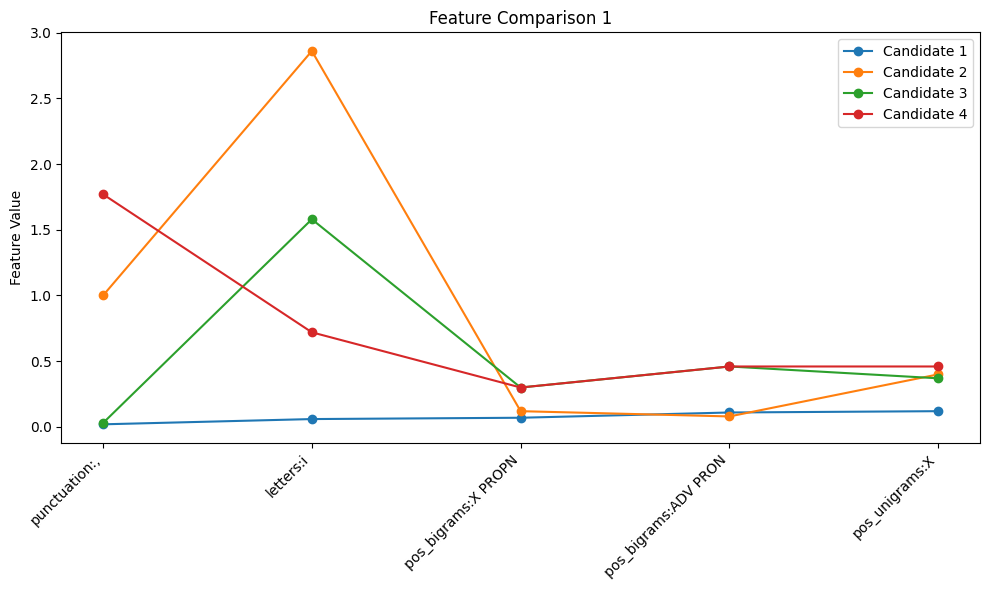

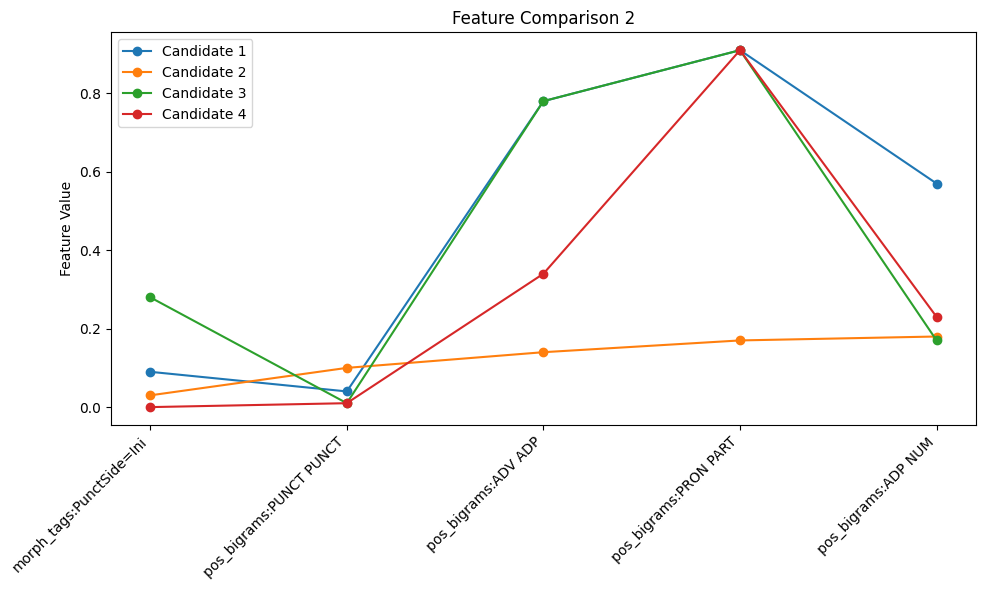

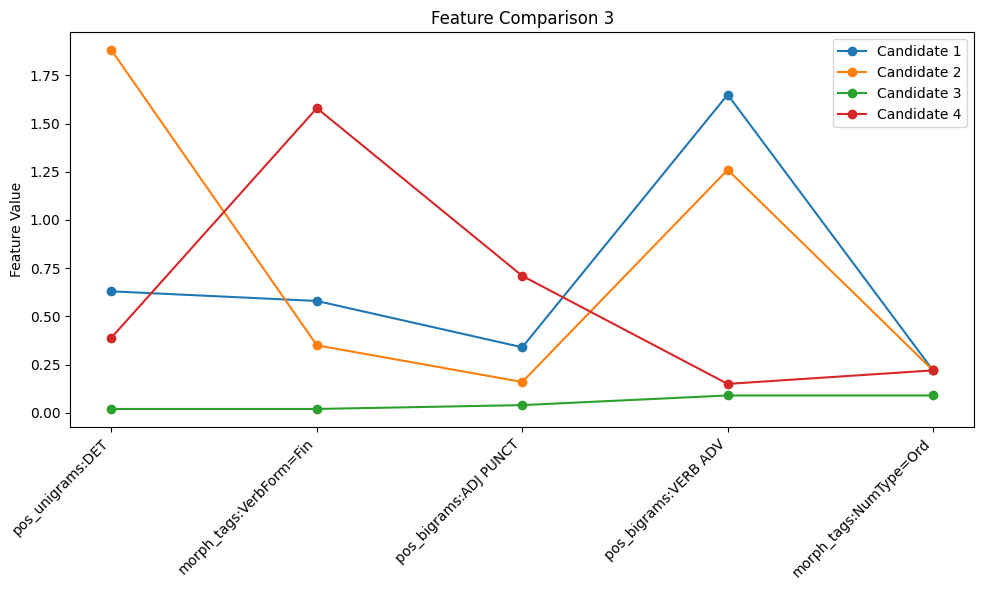

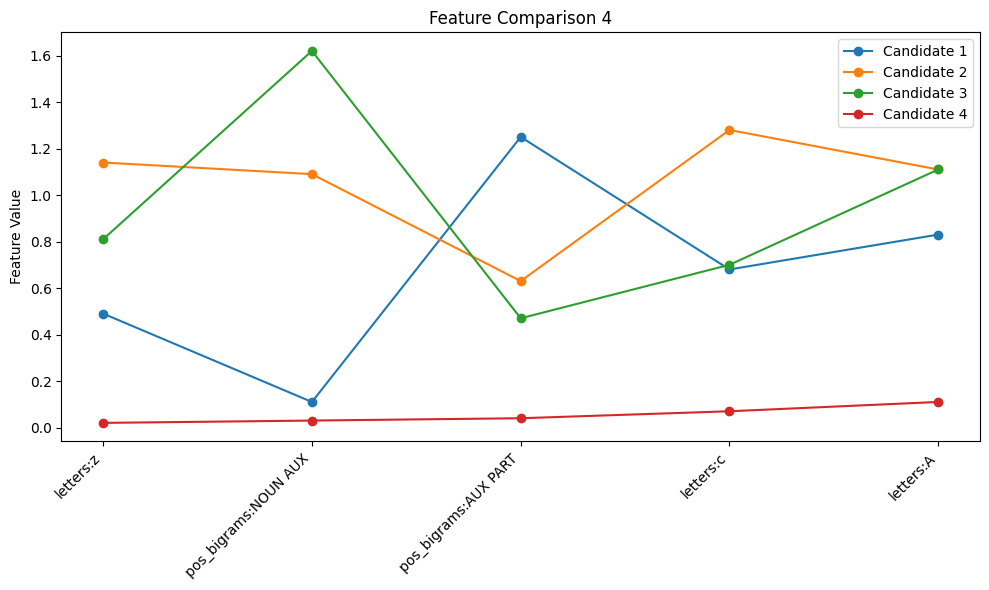

In [2]:
for example in eval_examples[:4]:
    print("The correct candidate is:", example.correct+1)
    print("Cosine Similarity between Chosen and Query is: ", example.max_cosim)
    print("Query Author: ", example.q_authorID, "Chosen Author: ", example.author)

    filtered_df = example.doc_features
    features = filtered_df.iloc[0].to_numpy()
    a0_indices, a1_indices, a2_indices, a3_indices = count_min_differences(example.doc_features)
    a0 = a0_indices[:5]
    a1 = a1_indices[:5]
    a2 = a2_indices[:5]
    a3 = a3_indices[:5]
    combined_top_indices = np.concatenate((a0, a1, a2, a3))
    filtered_df = filtered_df.iloc[:, combined_top_indices]
    print(filtered_df)
    differences_df = abs(filtered_df.iloc[1:] - filtered_df.iloc[0])

    # Reset index of the new DataFrame if needed
    differences_df = differences_df.reset_index(drop=True)
    num_features = differences_df.shape[1]
    num_plots = num_features // 5
    for i in range(num_plots):
        plt.figure(figsize=(10, 6))
        start_idx = i * 5
        end_idx = start_idx + 5
        x_ticks = differences_df.columns[start_idx:end_idx]
        plt.plot(x_ticks, differences_df.iloc[0, start_idx:end_idx], label='Candidate 1', marker='o')
        plt.plot(x_ticks, differences_df.iloc[1, start_idx:end_idx], label='Candidate 2', marker='o')
        plt.plot(x_ticks, differences_df.iloc[2, start_idx:end_idx], label='Candidate 3', marker='o')
        plt.plot(x_ticks, differences_df.iloc[3, start_idx:end_idx], label='Candidate 4', marker='o')
        
        plt.xticks(rotation=45, ha="right")
        plt.ylabel('Feature Value')
        plt.title(f'Feature Comparison {i+1}')
        plt.legend()
        plt.tight_layout()
        plt.show()

The correct candidate is: 1
Cosine Similarity between Chosen and Query is:  0.0314
Query Author:  0b01d356-42d8-0892-b058-efdbe26dadd1 Chosen Author:  0b01d356-42d8-0892-b058-efdbe26dadd1
   punctuation:,  letters:i  pos_bigrams:X PROPN  pos_bigrams:ADV PRON  pos_unigrams:X
0           0.29       0.72                -0.28                 -0.41           -0.28
1           0.27       0.78                -0.21                 -0.30           -0.16
2          -0.71      -2.14                -0.40                 -0.33           -0.68
3           0.26      -0.86                -0.58                 -0.87           -0.65
4          -1.48       0.00                -0.58                 -0.87           -0.74
   morph_tags:PunctSide=Ini  pos_bigrams:PUNCT PUNCT  pos_bigrams:ADV ADP  pos_bigrams:PRON PART  pos_bigrams:ADP NUM
0                      0.13                    -0.10                -0.47                   0.31                 0.11
1                      0.04                    -0.06  

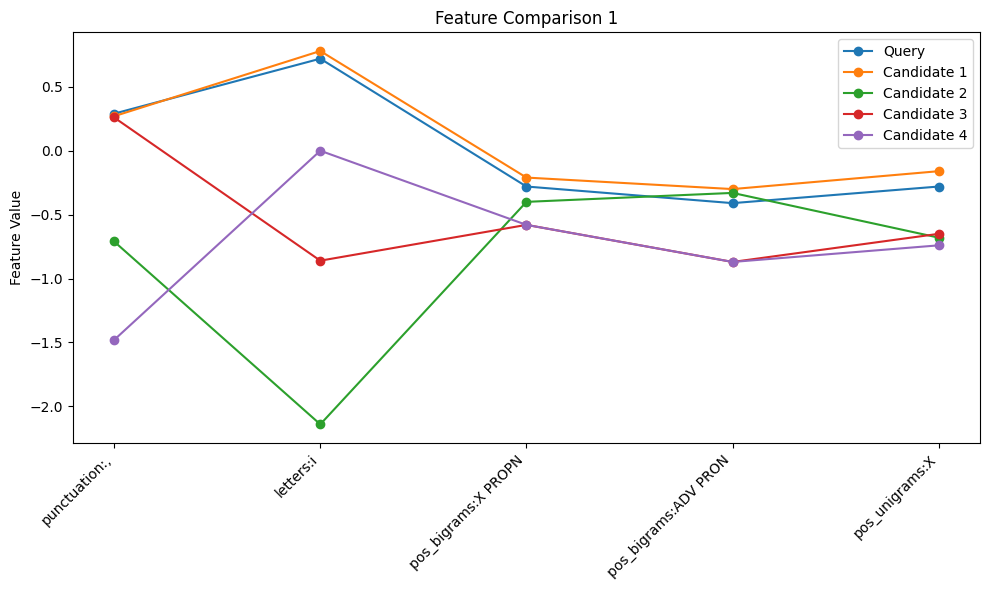

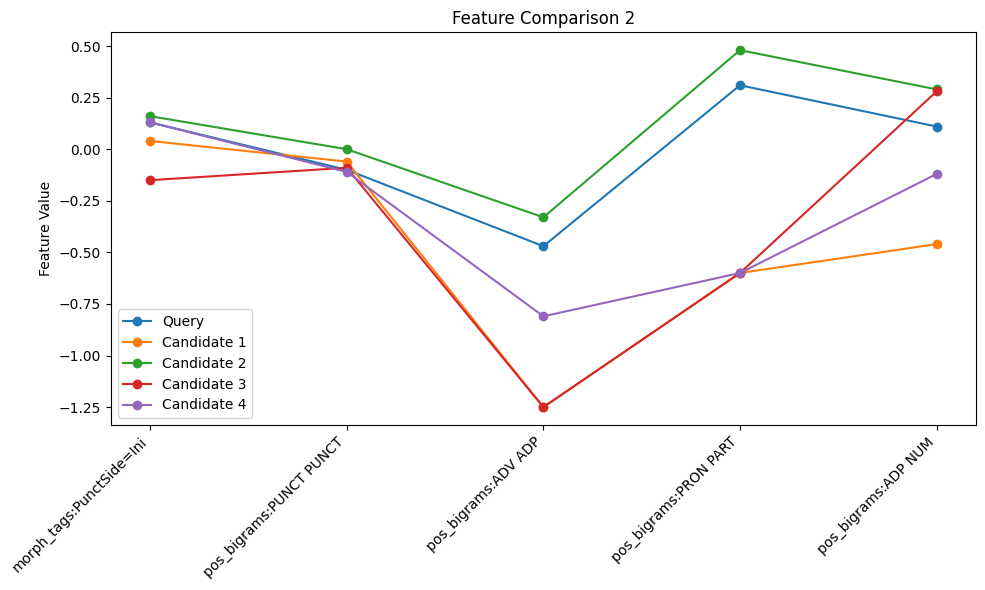

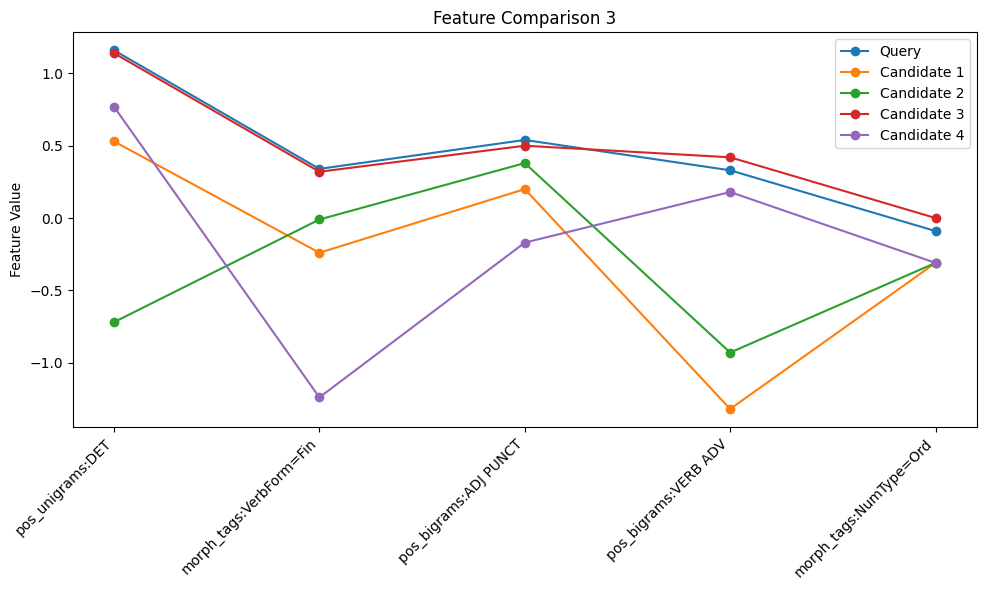

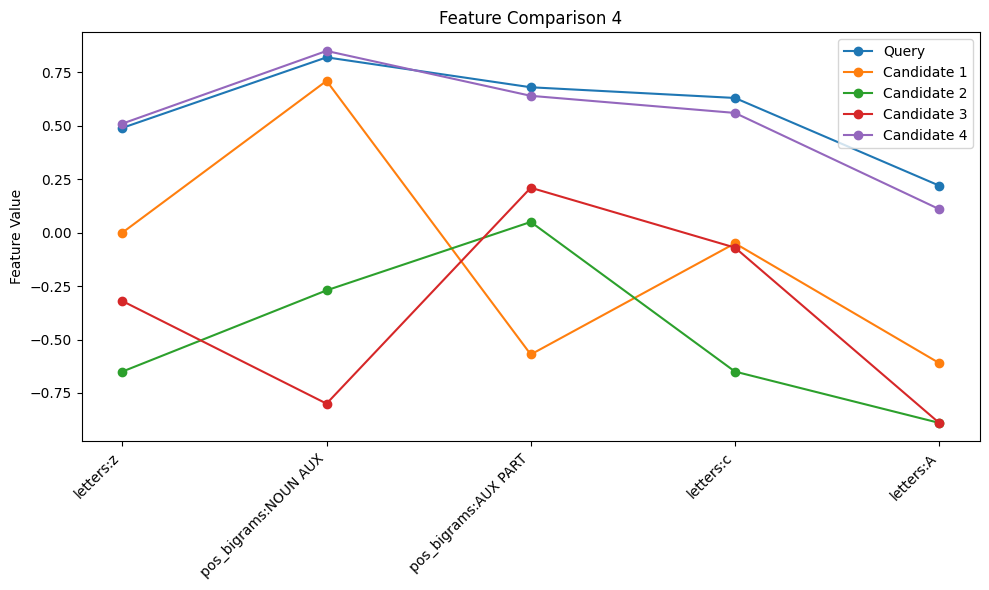

In [3]:
import matplotlib.pyplot as plt
for example in eval_examples[:1]:
    print("The correct candidate is:", example.correct+1)
    print("Cosine Similarity between Chosen and Query is: ", example.max_cosim)
    print("Query Author: ", example.q_authorID, "Chosen Author: ", example.author)
    
    filtered_df = example.doc_features
    features = filtered_df.iloc[0].to_numpy()
    a0_indices, a1_indices, a2_indices, a3_indices = count_min_differences(example.doc_features)
    a0 = a0_indices[:5]
    a1 = a1_indices[:5]
    a2 = a2_indices[:5]
    a3 = a3_indices[:5]
    combined_top_indices = np.concatenate((a0, a1, a2, a3))
    filtered_df = filtered_df.iloc[:, combined_top_indices]
    # print(len(top_n_features_index))
    # print(filtered_df.to_string())
    for i in range(0, filtered_df.shape[1], 5):
        print(filtered_df.iloc[:, i:i+5].to_string())

    
    num_features = filtered_df.shape[1]
    num_plots = num_features // 5
    for i in range(num_plots):
        plt.figure(figsize=(10, 6))
        start_idx = i * 5
        end_idx = start_idx + 5
        x_ticks = filtered_df.columns[start_idx:end_idx]
        plt.plot(x_ticks, filtered_df.iloc[0, start_idx:end_idx], label='Query', marker='o')
        plt.plot(x_ticks, filtered_df.iloc[1, start_idx:end_idx], label='Candidate 1', marker='o')
        plt.plot(x_ticks, filtered_df.iloc[2, start_idx:end_idx], label='Candidate 2', marker='o')
        plt.plot(x_ticks, filtered_df.iloc[3, start_idx:end_idx], label='Candidate 3', marker='o')
        plt.plot(x_ticks, filtered_df.iloc[4, start_idx:end_idx], label='Candidate 4', marker='o')
        
        plt.xticks(rotation=45, ha="right")
        plt.ylabel('Feature Value')
        plt.title(f'Feature Comparison {i+1}')
        plt.legend()
        plt.tight_layout()
        plt.show()
# turn into line graphs


